# Pattern Identification

Identify patterns of price action with the goal of correctly suggesting a profitable trade of slightly over 50% win rate.

**Import libraries**

In [841]:
import yfinance as yf
import pandas as pd
import numpy as np

**Retrieve data**

In [842]:
# get the data from last 60 days until the present
# dataF = yf.download("EURJPY=X", start="2023-10-18", end="2023-12-14", interval='15m')
# dataF = yf.download("EURJPY=X", period="60d", interval='15m')
# dataF = yf.download("EURJPY=X", period="365d", interval='1h')
# dataF = yf.download("EURJPY=X", period="365d", interval='1h')
dataF = yf.download("EURUSD=X", period="60d", interval='15m')
# dataF = yf.download("EURUSD=X", period="365d", interval='1h')
# dataF = yf.download("^NDX", period="365d", interval='1h')

# dataF.iloc[:,:]
#dataF.Open.iloc

[*********************100%%**********************]  1 of 1 completed


In [843]:
df = pd.DataFrame(dataF)

# use df index, convert DateTime to  a column instead of index
df.reset_index(inplace=True)

# delete Adj Close
df = df.drop(['Adj Close'], axis=1)

# rename Datetime to "Gmt time"
df = df.rename(columns={'Datetime':'Gmt time'})
df

,Gmt time,Open,High,Low,Close,Volume
0,2023-10-02 00:00:00,1.056189,1.056301,1.056078,1.056189,0
1,2023-10-02 00:15:00,1.056301,1.056412,1.056301,1.056412,0
2,2023-10-02 00:30:00,1.056412,1.056636,1.056189,1.056636,0
3,2023-10-02 00:45:00,1.056636,1.056747,1.056524,1.056636,0
4,2023-10-02 01:00:00,1.056636,1.056971,1.056524,1.056747,0
...,...,...,...,...,...,...
5679,2023-12-22 21:15:00,1.101322,1.101443,1.101322,1.101443,0
5680,2023-12-22 21:30:00,1.101443,1.101443,1.101322,1.101443,0
5681,2023-12-22 21:45:00,1.101443,1.101928,1.101322,1.101322,0
5682,2023-12-22 22:00:00,1.101443,1.101443,1.101443,1.101443,0


In [844]:
df['Gmt time']=pd.to_datetime(df['Gmt time'],format='%d.%m.%Y %H:%M:%S')
df.set_index("Gmt time", inplace=True)
df=df[df.High!=df.Low]
len(df)

5642

In [845]:
import pandas_ta as ta
df["MACD"]=ta.macd(df.Close)['MACD_12_26_9']
df["MACD_HIST"]=ta.macd(df.Close)['MACDh_12_26_9']
df["MACD_SIGNAL"]=ta.macd(df.Close)['MACDs_12_26_9']
df["ADX"]=ta.adx(df.High, df.Low, df.Close)['ADX_14']
df["20_MA"] = ta.ema(df.Close, length=20)
df["50_MA"] = ta.ema(df.Close, length=50)
df["100_MA"] = ta.ema(df.Close, length=100)
df["200_MA"]= ta.ema(df.Close, length=200)
# df["HA_OPEN"]=ta.ha(df.Open, df.High, df.Low, df.Close)['HA_open']
# df["HA_CLOSE"]=ta.ha(df.Open, df.High, df.Low, df.Close)['HA_close']


df['RSI']=ta.rsi(df.Close, length=16)
df['MA_200']=ta.sma(df.Close, length=200)
my_bbands = ta.bbands(df.Close, length=14, std=2.0)
df=df.join(my_bbands)

/var/folders/mb/tyl8xvh9689bgk14qr31lc7r0000gn/T/ipykernel_61200/2225469480.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/mb/tyl8xvh9689bgk14qr31lc7r0000gn/T/ipykernel_61200/2225469480.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/mb/tyl8xvh9689bgk14qr31lc7r0000gn/T/ipykernel_61200/2225469480.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

## Session Time Zones

This table shows the start and end times of various market sessions in both Thailand Time and GMT.

| Session | Thailand Time (TH) | GMT (UTC) |
|---|---|---|
| Tokyo Session | 08:00 - 16:00 | 01:00 - 09:00 |
| London Session | 15:00 - 24:00 | 07:00 - 16:00 |
| New York Session | 20:00 - 05:00 (Next Day) | 13:00 - 22:00 (Next Day) |

In [846]:
# separate the data into list of daily dataframes
dailyDataList = []

for row in range(1, len(df)):
    if df.index[row].day != df.index[row-1].day:
        dailyData = {
            "date": df.index[row].date(),
            "priceData": df.iloc[row-96:row,:],
            "trend": None,
            "high": None,
            "low": None,
            "mean": None
        }
        dailyDataList.append(dailyData)

In [847]:
dailyDataList[0]

{'date': datetime.date(2023, 10, 3),
 'priceData':                          Open      High       Low     Close  Volume      MACD  \
 Gmt time                                                                        
 2023-10-02 00:00:00  1.056189  1.056301  1.056078  1.056189       0       NaN   
 2023-10-02 00:15:00  1.056301  1.056412  1.056301  1.056412       0       NaN   
 2023-10-02 00:30:00  1.056412  1.056636  1.056189  1.056636       0       NaN   
 2023-10-02 00:45:00  1.056636  1.056747  1.056524  1.056636       0       NaN   
 2023-10-02 01:00:00  1.056636  1.056971  1.056524  1.056747       0       NaN   
 ...                       ...       ...       ...       ...     ...       ...   
 2023-10-02 22:45:00  1.048108  1.048328  1.048108  1.048218       0 -0.000869   
 2023-10-02 23:00:00  1.048218  1.048438  1.047998  1.048438       0 -0.000811   
 2023-10-02 23:15:00  1.048438  1.048548  1.048438  1.048548       0 -0.000748   
 2023-10-02 23:30:00  1.048438  1.048548  1.0482

In [848]:
slopes = []
date_trend_map = {}
date_median_map = {}

In [849]:
# from daily data, extract the trend. determine if the overall trend is upwards or downwards
# use intraday trend, 3 days trend, 1 week trend

# determine the intraday trend from the price structure. Linear fit the prices to a line and determine the slope

for i in range(len(dailyDataList)):
    dailyData = dailyDataList[i]
    # get the data between 1:00 and 13:00. use the Gmt time column
    # Create a mask for the time range
    tokyo_and_london_mask = (dailyData['priceData'].index.time >= pd.to_datetime('07:00').time()) & (dailyData['priceData'].index.time <= pd.to_datetime('12:00').time())

    # if (tokyo_and_london_df.empty):
    #     continue

    tokyo_and_london_df = dailyData['priceData'].loc[tokyo_and_london_mask]
    tokyo_and_london_df

    x = np.arange(len(tokyo_and_london_df))
    y = tokyo_and_london_df['Close'].values
    # y = (tokyo_and_london_df['Open'] + tokyo_and_london_df['Close']) / 2


    # Fit the prices to a line
    if (len(y) == 0 | len(x) == 0):
        coefficients = [0, 0]
    else:
        coefficients = np.polyfit(x, y, 1)

    # The slope of the line is the first coefficient
    slope = coefficients[0]
    slopes.append(slope)

    dailyDataList[i]['trend'] = slope
    dailyDataList[i]['high'] = tokyo_and_london_df['High'].max()
    dailyDataList[i]['low'] = tokyo_and_london_df['Low'].min()
    dailyDataList[i]['mean'] = tokyo_and_london_df['Close'].mean()
    dailyDataList[i]['median'] = (dailyDataList[i]['high'] + dailyDataList[i]['low']) / 2

    date = dailyDataList[i]['date'] 
    date_trend_map[date] = slope
    date_median_map[date] = dailyDataList[i]['median']

    print(f"The slope of the trend line is {slope}")

The slope of the trend line is -0.00025361358345327216
The slope of the trend line is 5.034192816005277e-05
The slope of the trend line is 0.0002778427941458502
The slope of the trend line is 2.7289173819807017e-05
The slope of the trend line is 0.00011404783694777278
The slope of the trend line is -6.020223939573089e-05
The slope of the trend line is 0.00023895037638677264
The slope of the trend line is -2.9247457330870324e-05
The slope of the trend line is -8.113941588957767e-05
The slope of the trend line is -0.00013132575270417057
The slope of the trend line is 5.7647754619753255e-06
The slope of the trend line is 8.374050066067453e-05
The slope of the trend line is -0.00015074370743390847
The slope of the trend line is 8.046921197470408e-05
The slope of the trend line is 0.00011867563445846044
The slope of the trend line is 0.00013206314730951813
The slope of the trend line is -0.0003307003479499193
The slope of the trend line is -0.0001518088501769206
The slope of the trend line 

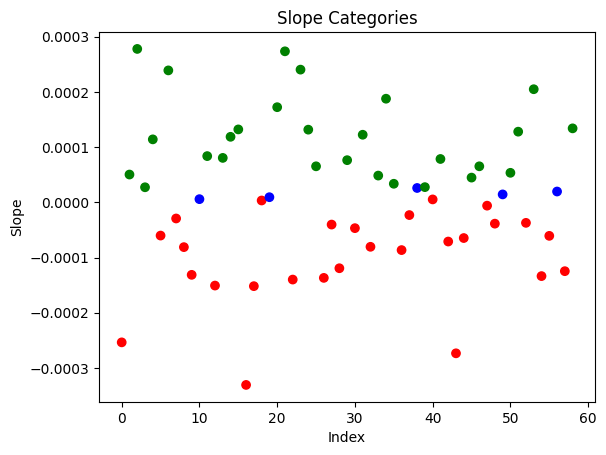

In [850]:
# plot the slopes and categorize them into 3 categories: upwards, downwards, sideways based on the percentile of the slope

import matplotlib.pyplot as plt
import numpy as np

# Assuming `slopes` is a list of slopes
slopes = np.array(slopes)
# remove empty values

# Define the percentile thresholds for the categories
upwards_threshold = np.percentile(slopes, 55)
downwards_threshold = np.percentile(slopes, 45)

# Categorize the slopes
categories = np.empty_like(slopes, dtype=object)
categories[slopes >= upwards_threshold] = 'upwards'
categories[slopes <= downwards_threshold] = 'downwards'
categories[(slopes > downwards_threshold) & (slopes < upwards_threshold)] = 'sideways'

color_map = {'upwards': 'green', 'downwards': 'red', 'sideways': 'blue'}
colors = [color_map[category] for category in categories]

# Plot the slopes with their categories
plt.scatter(range(len(slopes)), slopes, c=colors)
plt.xlabel('Index')
plt.ylabel('Slope')
plt.title('Slope Categories')
plt.show()


In [851]:
for i in range(len(dailyDataList)):
    dailyData = dailyDataList[i]
    if (dailyData['trend'] > upwards_threshold):
        dailyDataList[i]['trend'] = 'upwards'
    elif (dailyData['trend'] < downwards_threshold):
        dailyDataList[i]['trend'] = 'downwards'
    else:
        dailyDataList[i]['trend'] = 'sideways'
    print(f"The trend is {dailyDataList[i]['trend']}")

The trend is downwards
The trend is upwards
The trend is upwards
The trend is upwards
The trend is upwards
The trend is downwards
The trend is upwards
The trend is downwards
The trend is downwards
The trend is downwards
The trend is sideways
The trend is upwards
The trend is downwards
The trend is upwards
The trend is upwards
The trend is upwards
The trend is downwards
The trend is downwards
The trend is downwards
The trend is sideways
The trend is upwards
The trend is upwards
The trend is downwards
The trend is upwards
The trend is upwards
The trend is upwards
The trend is downwards
The trend is downwards
The trend is downwards
The trend is upwards
The trend is downwards
The trend is upwards
The trend is downwards
The trend is upwards
The trend is upwards
The trend is upwards
The trend is downwards
The trend is downwards
The trend is sideways
The trend is upwards
The trend is downwards
The trend is upwards
The trend is downwards
The trend is downwards
The trend is downwards
The trend 

In [852]:
signal = [0]*len(df)

for row in range(1, len(df)):
  isTradingTime = df.index[row].hour == 13 and df.index[row].minute == 0
  if (not isTradingTime):
    continue

  slope = date_trend_map.get(df.index[row].date())
  if (slope != None and slope > upwards_threshold):
    # print(f"Buy at {df.iloc[row,0]}")
    hasSetup = True
    signal[row]=-1
  elif (slope != None and slope < downwards_threshold):
    # print(f"Sell at {df.iloc[row,0]}")
    hasSetup = True
    signal[row]=1
  else:
    hasSetup = False
    signal[row]=0

df['signal'] = signal


In [853]:
def TotalSignal(l):
    # if (df.VWAPSignal[l]==2
    #     and df.Close[l]<=df['BBL.0'][l]
    #     and df.RSI[l]<45):
    #         return 2
    # if (df.VWAPSignal[l]==1
    #     and df.Close[l]>=df['BBU.0'][l]
    #     and df.RSI[l]>55):
    #         return 1
    # return 0
    

    if (
        True
        and df.signal[l]==1
        # and (
        #     # df["20_MA"][l] > df["50_MA"][l]
        # )
        # and df["Close"][l] > df["200_MA"][l]
        
    ):
            return 2
    if (
        True
        and df.signal[l]==-1
        # and (
        #     # df["20_MA"][l] < df["50_MA"][l]
        # )
        # and df["Close"][l] < df["200_MA"][l]
    ):
            return 1
    return 0
        
TotSignal = [0]*len(df)
for row in range(0, len(df)): #careful backcandles used previous cell
    TotSignal[row] = TotalSignal(row)
df['TotalSignal'] = TotSignal

/var/folders/mb/tyl8xvh9689bgk14qr31lc7r0000gn/T/ipykernel_61200/4011679497.py:15: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/mb/tyl8xvh9689bgk14qr31lc7r0000gn/T/ipykernel_61200/4011679497.py:25: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



In [854]:
df[df.TotalSignal!=0].count()

Open           54
High           54
Low            54
Close          54
Volume         54
MACD           54
MACD_HIST      54
MACD_SIGNAL    54
ADX            54
20_MA          54
50_MA          54
100_MA         54
200_MA         53
RSI            54
MA_200         53
BBL_14_2.0     54
BBM_14_2.0     54
BBU_14_2.0     54
BBB_14_2.0     54
BBP_14_2.0     54
signal         54
TotalSignal    54
dtype: int64

In [855]:
import numpy as np
def pointposbreak(x):
    if x['TotalSignal']==1:
        return x['High']+1e-4
    elif x['TotalSignal']==2:
        return x['Low']-1e-4
    else:
        return np.nan

df['pointposbreak'] = df.apply(lambda row: pointposbreak(row), axis=1)

In [856]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime
st=0
dfpl = df[st:st+ len(df)]
dfpl.reset_index(inplace=True)
fig = go.Figure(data=[go.Candlestick(x=dfpl.index,
                open=dfpl['Open'],
                high=dfpl['High'],
                low=dfpl['Low'],
                close=dfpl['Close']),
                # go.Scatter(x=dfpl.index, y=dfpl.VWAP, 
                #            line=dict(color='blue', width=1), 
                #            name="VWAP"), 
                # go.Scatter(x=dfpl.index, y=dfpl['BBL.0'], 
                #            line=dict(color='green', width=1), 
                #            name="BBL"),
                # go.Scatter(x=dfpl.index, y=dfpl['BBU.0'], 
                #            line=dict(color='green', width=1), 
                #            name="BBU")
                go.Scatter(x=dfpl.index, y=dfpl['100_MA'],
                            line=dict(color='red', width=1), 
                            name="100_MA"),
      ])

fig.add_scatter(x=dfpl.index, y=dfpl['pointposbreak'], mode="markers",
                marker=dict(size=10, color="MediumPurple"),
                name="Signal")

# set figure size
fig.update_layout(
    autosize=False,
    width=1600,
    height=1000,
    margin=dict(l=50,r=50,b=100,t=100,pad=4)
)

fig.show()

In [857]:
dfpl = df[:75000].copy()
import pandas_ta as ta
dfpl['ATR']=ta.atr(dfpl.High, dfpl.Low, dfpl.Close, length=24)
#help(ta.atr)
def SIGNAL():
    return dfpl.TotalSignal

In [858]:
from backtesting import Strategy
from backtesting import Backtest

class MyStrat(Strategy):
    initsize = 0.04
    mysize = initsize
    def init(self):
        super().init()
        self.signal1 = self.I(SIGNAL)

    def next(self):
        super().next()
        slatr = 5*self.data.ATR[-1]
        TPSLRatio = 1.5
        
        # buy
        if self.signal1==2 and len(self.trades)==0:
            # entry = self.data.Close[-1]
            entry =self.data.Close[-1]
            london_median = date_median_map.get(self.data.index[-1].date())
            print("London median: ", london_median)
            if (entry > london_median):
                entry = london_median
            sl1 = entry - slatr
            tp1 = entry + slatr*TPSLRatio
            self.buy(sl=sl1, tp=tp1, size=self.mysize, limit=entry)
            print("Buy", self.data.Close[-1])
            print("Stop loss: ", sl1)
            print("Take profit: ", tp1)
            print("------")
        
        # sell
        elif self.signal1==1 and len(self.trades)==0:   
            # entry = self.data.Close[-1]    
            entry =self.data.Close[-1]
            london_median = date_median_map.get(self.data.index[-1].date())
            print("London median: ", london_median)
            if (entry < london_median):
                entry = london_median
            sl1 = entry + slatr
            tp1 = entry - slatr*TPSLRatio
            # place a sell limit order
            self.sell(sl=sl1, tp=tp1, size=self.mysize, limit=entry)
            print("Sell", self.data.Close[-1])
            print("Stop loss: ", sl1)
            print("Take profit: ", tp1)
            print("------")

In [859]:
bt = Backtest(dfpl, MyStrat, cash=50000, margin=1/100, commission=0.00)
stat = bt.run()

London median:  1.056420385837555
Buy 1.0477787256240845
Stop loss:  1.0450610631843547
Take profit:  1.051855219283679
------
London median:  1.048055350780487
Sell 1.0500892400741577
Stop loss:  1.0532332446978339
Take profit:  1.0453732331386434
------
London median:  1.0487767457962036
Sell 1.0526316165924072
Stop loss:  1.0553647060763232
Take profit:  1.048531982366533
------
London median:  1.0515256524085999
Sell 1.0561892986297607
Stop loss:  1.05869334212583
Take profit:  1.0524332333856568
------
London median:  1.0550214052200317
Sell 1.0530749559402466
Stop loss:  1.0579175282059705
Take profit:  1.0506772207411235
------
London median:  1.0542438626289368
Buy 1.0585371255874634
Stop loss:  1.0512071626912267
Take profit:  1.058798912535502
------
London median:  1.0586002469062805
Sell 1.0604453086853027
Stop loss:  1.0632256704664862
Take profit:  1.0562747660135277
------
London median:  1.0612351894378662
Buy 1.062134861946106
Stop loss:  1.0591864339803183
Take profit

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/backtesting/backtesting.py:952: UserWarning:

(2023-10-12 13:30:00) A contingent SL/TP order would execute in the same bar its parent stop/limit order was turned into a trade. Since we can't assert the precise intra-candle price movement, the affected SL/TP order will instead be executed on the next (matching) price/bar, making the result (of this trade) somewhat dubious. See https://github.com/kernc/backtesting.py/issues/119

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/backtesting/backtesting.py:952: UserWarning:

(2023-12-12 13:30:00) A contingent SL/TP order would execute in the same bar its parent stop/limit order was turned into a trade. Since we can't assert the precise intra-candle price movement, the affected SL/TP order will instead be executed on the next (matching) price/bar, making the result (of this trade) somewhat dubious. See https://github.com/kernc/backt

In [860]:
print(stat)

Start                     2023-10-02 00:00:00
End                       2023-12-22 21:45:00
Duration                     81 days 21:45:00
Exposure Time [%]                   29.688054
Equity Final [$]                 51464.917739
Equity Peak [$]                  52320.305464
Return [%]                           2.929835
Buy & Hold Return [%]                4.273124
Return (Ann.) [%]                   12.894652
Volatility (Ann.) [%]               17.923346
Sharpe Ratio                         0.719433
Sortino Ratio                        1.244688
Calmar Ratio                         2.970841
Max. Drawdown [%]                   -4.340405
Avg. Drawdown [%]                   -1.007233
Max. Drawdown Duration       25 days 07:00:00
Avg. Drawdown Duration        3 days 00:24:00
# Trades                                   43
Win Rate [%]                        46.511628
Best Trade [%]                       0.431906
Worst Trade [%]                     -0.370525
Avg. Trade [%]                    

In [861]:
bt.plot(show_legend=False)

Row(id='38286', ...)